# Introduction
In the [previous posts](https://shriv.github.io/Playgrounds-vs-pubs/), we calculated accessibility in terms of distance. Distance is an excellent metric for driving or walking on flat land. For short travels by car or walking on flat land, distance can be directly converted to travel time. Most people have an intuitive understanding of their average driving speeds (50 km/h for residential roads in New Zealand) or their approximate walking speed on flat land (usually around 5 km / h for a fit adult as given in [Section 3.4 in NZTA pedestrian planning and design guide](https://www.nzta.govt.nz/assets/resources/pedestrian-planning-guide/docs/pedestrian-planning-guide.pdf)). Hills are not an issue for drivers provided road quality and safety are no different to flat land. But hills do impact travel time for pedestrians; which in turn impacts accessibility. 

> _How prohibitive is Wellington’s topography on pedestrian accessibility to playgrounds?_

Playgrounds are key amenities that can impact the quality of life for young families. Since they are also frequently accessed on foot, it's important to consider how accessible they really are. Particularly for suburbs with a high residential fraction.   

## Tasks
- Calculate the impact of walking in hilly terrain on travel time to council playgrounds in Wellington
- Compare the travel times to playground for the largest residential suburbs in Wellington
- Model the average travel time to a playground by suburb 


## Technical details
To do this analysis, we need to overcome some technical aspects:
- Re-do accessibility analysis: from distance to travel time
- Get elevation data for roads and walkways
- Convert elevation to road / walkway inclination 
- Incorporate inclination in the accessibility analysis
    - Include road inclines in the pandana network
    - Estimate the impact of inclination on travel time
    
## Datasets

There are 2 key datasets used in this analysis:
- *WCC playground locations*: downloaded as a zip file
- *Wellington street network*
    - without elevation: using OpenStreetMap via *osmnx*


In [104]:
# Import some packages
import warnings
import os
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import geopandas 
import numpy as np
import seaborn as sns
import folium
from importlib import reload
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
    

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=False)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [86]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.38,174.84,-41.1527]
# general_bbox = [174.57,-41.20,174.58,-41.19]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

# WCC Playgrounds

In [115]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds.iloc[32:35]

,OBJECTID,location,suburb,playground,Housing,geometry
32,33,Kipling Street,Johnsonville,Kipling Street Play Area,No,POINT (174.79808 -41.22495)
33,34,Fraser Avenue,Johnsonville,Gilbert Young Play Area,No,POINT (174.80352 -41.22934)
34,35,Kanpur Road/Rajkot Terrace,Broadmeadows,Kanpur Road Play Area,No,POINT (174.79564 -41.23611)


In [114]:
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds.iloc[32:35]

,OBJECTID,location,suburb,playground,Housing,geometry,lon,lat
32,33,Kipling Street,Johnsonville,Kipling Street Play Area,No,POINT (174.79808 -41.22495),174.798078,-41.224946
33,34,Fraser Avenue,Johnsonville,Gilbert Young Play Area,No,POINT (174.80352 -41.22934),174.803516,-41.229338
34,35,Kanpur Road/Rajkot Terrace,Broadmeadows,Kanpur Road Play Area,No,POINT (174.79564 -41.23611),174.795639,-41.236107


In [102]:
map_playground = folium.Map(location=[wcc_playgrounds.iloc[32]['lat'], 
                                      wcc_playgrounds.iloc[32]['lon']],
                            fit_bounds=True,
                            zoom_start = 14)

folium.Marker(location = [wcc_playgrounds.iloc[32]['lat'], 
                          wcc_playgrounds.iloc[32]['lon']], 
              popup = wcc_playgrounds.iloc[32]['playground']).add_to(map_playground)

map_playground

# What is a graph?

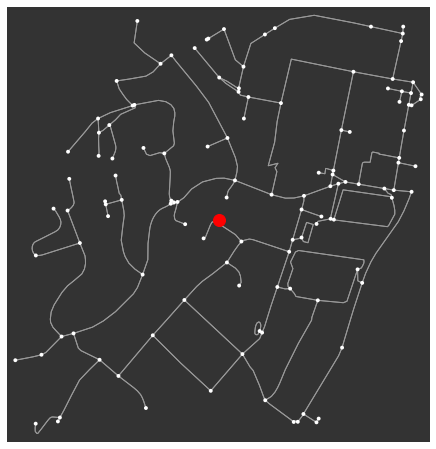

In [113]:
G_sub = ox.graph_from_point((wcc_playgrounds.iloc[32]['lat'], wcc_playgrounds.iloc[32]['lon']), dist=500, network_type='walk');
fig, ax = ox.plot_graph(G_sub, close=False, show=False, bgcolor="#333333")
ax.plot(wcc_playgrounds.iloc[32]['lon'], wcc_playgrounds.iloc[32]['lat'], 'o', color='red', markersize=12)

In [123]:
ox.plot_graph_folium(G_sub, map_playground)

## Graph data

In [122]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_sub)
display(gdf_nodes.head())
display(gdf_edges.head())

,y,x,street_count,highway,geometry
osmid,,,,,
178172965,-41.229399,174.800267,3,NaN,POINT (174.80027 -41.22940)
178172966,-41.229396,174.800385,3,NaN,POINT (174.80039 -41.22940)
206203155,-41.228922,174.799432,3,NaN,POINT (174.79943 -41.22892)
206203164,-41.227905,174.798765,4,NaN,POINT (174.79876 -41.22791)
331131383,-41.224332,174.803716,4,traffic_signals,POINT (174.80372 -41.22433)


osmid             name  \
u         v          key                                           
178172965 206203155  0                329990724    Haumia Street   
          178172966  0                329990725              NaN   
178172966 6083915719 0                329990722  Moorefield Road   
          178172965  0                329990725              NaN   
206203155 4946722007 0    [19792090, 220444691]    Fisher Street   

                                         highway maxspeed  oneway   length  \
u         v          key                                                     
178172965 206203155  0               residential       50   False   87.755   
          178172966  0                 secondary      NaN   False   10.955   
178172966 6083915719 0                 secondary       50   False   23.536   
          178172965  0                 secondary      NaN   False   10.955   
206203155 4946722007 0    [footway, residential]       50   False  280.415   

                                                                   geometry  \
u         v          key                                                      
178172965 206203155  0    LINESTRING (174.80027 -41.22940, 174.80015 -41...   
          178172966  0    LINESTRING (174.80027 -41.22940, 174.80029 -41...   
178172966 6083915719 0    LINESTRING (174.80039 -41.22940, 174.80051 -41...   
          178172965  0    LINESTRING (174.80039 -41.22940, 174.80036 -41...   
206203155 4946722007 0    LINESTRING (174.79943 -41.22892, 174.79961 -41...   

                            junction service  
u         v          key                      
178172965 206203155  0           NaN     NaN  
          178172966  0    roundabout     NaN  
178172966 6083915719 0           NaN     NaN  
          178172965  0    roundabout     NaN  
206203155 4946722007 0           NaN     NaN

# Wellington street network
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

In [116]:
# Create an OSMNX walking street netwoek for the Wellington bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

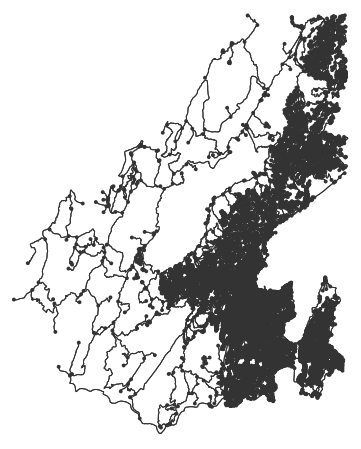

In [131]:
# ec = ox.get_edge_colors_by_attr(G, 'grade', cmap='viridis', num_bins=10)
fig, ax = ox.plot_graph(G, bgcolor="#ffffff", node_color="#333333", edge_color="#333333")

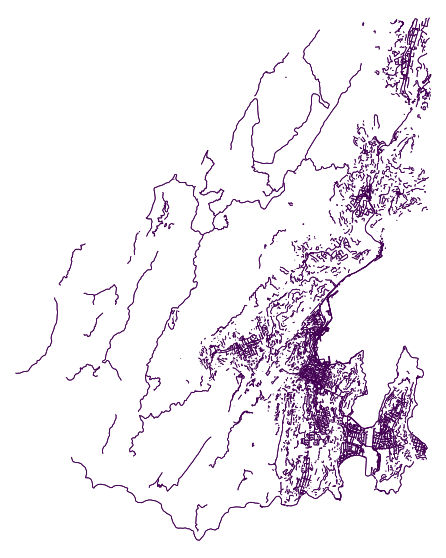

In [51]:
# Create copy of the osmnx network
G_flat = G.copy()

# Identify edges that have an absolute incline greater than 5%
flat_land = [(u, v, k) for u, v, k, d 
             in G.edges(keys=True, data=True) 
             if not (d['grade'] > -0.05 and d['grade'] < 0.05)]

# Remove hilly edges of the street network
G_flat.remove_edges_from(flat_land)
G_flat = ox.remove_isolated_nodes(G_flat)

# Don't seem to need this
#G_flat = ox.simplify_graph(G_flat)

# Generate plot
ec = ox.get_edge_colors_by_attr(G_flat, 'grade', cmap='viridis', num_bins=1)
fig, ax = ox.plot_graph(G_flat, fig_height=10, edge_color=ec, edge_linewidth=0.8, node_size=0, show=True, use_geom=True)

# Accessibility analysis 

## Walkability - distance

In [12]:
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'

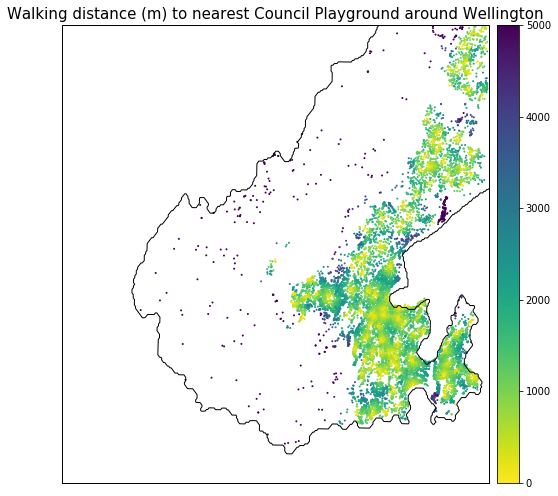

In [13]:
# Create a pandana network with data extracted from an OSMNX graph
flat_distance_network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                                   edges_gdfs['u'], edges_gdfs['v'], 
                                   edges_gdfs[['length']])

# Calculate accessibility
playground_accessibility_flat = aa.get_accessibility(flat_distance_network, 
                                                     wcc_playgrounds, distance=2500, num_pois=10)

# Plot accessibility
aa.plot_accessibility(flat_distance_network, playground_accessibility_flat[1]*2, osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

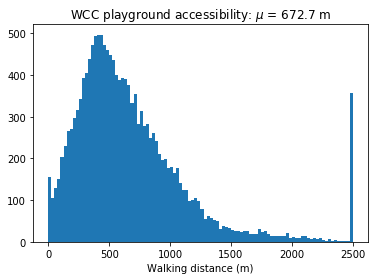

In [14]:
plt.hist(playground_accessibility_flat[1], bins=100);
plt.xlabel('Walking distance (m)');
plt.title("WCC playground accessibility: $\mu$ = {:.1f} m".format(np.mean(playground_accessibility_flat[1])));

## Converting distance to travel time

A [simple search](https://books.google.co.nz/books?id=SyulBQAAQBAJ&pg=PA160&lpg=PA160&dq=walking+speed+gradient+accessibility&source=bl&ots=iKmtg73TIV&sig=ACfU3U3N5CAAtqoA0QzfSpJubylfjneWtA&hl=en&sa=X&ved=2ahUKEwiqqeKj3YTgAhVQXn0KHdSFDWsQ6AEwAHoECAkQAQ#v=onepage&q=walking%20speed%20gradient%20accessibility&f=false) led me to [Naismith's Rule](https://en.wikipedia.org/wiki/Naismith%27s_rule) and then to [Tobler's Hiking Function](https://en.wikipedia.org/wiki/Tobler%27s_hiking_function) to calculate travel time as a function of distance and gradient. 

I've chosen to go with Tobler's without too much rationale other than its simple form. Tobler's hiking function for speed, $\nu$, is a shifted exponential with three parameters: $a$, $b$ and $c$ which give the fastest speed, speed retardation due to gradient and shift from zero respectively. 

$$
\nu = a\exp^{\left(-b.|slope~+~c|\right)}
$$

Note that $slope$ here is the dimensionless quantity: $\frac{dh}{dx}$ (or, rise / run). Tobler's function can also be written with slope in degrees ($^{\circ}$). Speed in km/h can be converted to a travel time in minutes with the factor (60/1000). 

While I haven't read Tobler's original paper, a [brief exposition of other equivalent functional forms to Tobler's](https://rpubs.com/chrisbrunsdon/hiking) has been written up by Chris Brunsdon. For a more rigorous analysis, we'll need to refit the form above (or similar) as Brunsdon does for different types of pedestrians. According to NZTA and various other studies, there is significant heterogeneity in walking speed; noth from the route (terrain, incline etc) and also the characteristics of the walker e.g. carrying things, footwear, and demographics. We can likely imagine that a commuter will walk at a very different speed to a father taking his children to the playground during the daytime. Brunsdon's analysis itself shows a very different relationship to Tobler's. 

Function | a | b | c 
--- | --- | --- | ---
Tobler | 6 | 3.5 | 0.05 
Brunsdon | 3.557 | 2.03 | 0.133


In [15]:
# Function parameters
toblers = [6.0, 3.5, 0.05]
brunsdon = [3.557, 2.03, 0.13]

In [16]:
street_grades = np.arange(-0.4, 0.4, 0.001)
travel_time_df = pd.DataFrame({'grade':street_grades})
travel_time_df['distance'] = 100

travel_time_df['toblers'] = ut.hiking_time(travel_time_df['grade'], travel_time_df['distance'], params_list=toblers)
travel_time_df['brunsdon'] = ut.hiking_time(travel_time_df['grade'], travel_time_df['distance'], params_list=brunsdon)
travel_time_df['flat_5khr'] = ut.flat_travel_time(travel_time_df['distance'])
travel_time_df['flat_3khr'] = ut.flat_travel_time(travel_time_df['distance'], 3.0)

travel_speed_df = pd.DataFrame({'grade':street_grades})
travel_speed_df['toblers'] = ut.hiking_speed(travel_speed_df['grade'], params_list=toblers)
travel_speed_df['brunsdon'] = ut.hiking_speed(travel_speed_df['grade'], params_list=brunsdon)

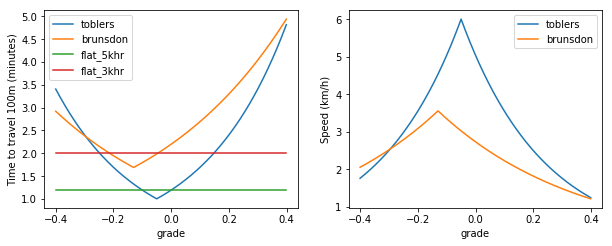

In [17]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(221)
travel_time_df[['toblers', 'brunsdon', 'flat_5khr', 'flat_3khr', 'grade']].plot(x='grade', ax = ax1)
plt.ylabel('Time to travel 100m (minutes)');

ax2 = plt.subplot(222)
travel_speed_df[['toblers', 'brunsdon','grade']].plot(x='grade', ax = ax2)
plt.ylabel('Speed (km/h)');


## Walkability - travel time

In [22]:

# Add the travel times 
edges_gdfs_undir['time_5khr'] = ut.flat_travel_time(edges_gdfs_undir['length'])
edges_gdfs_undir['time_tobler'] = ut.hiking_time(edges_gdfs_undir['grade'], edges_gdfs_undir['length'], params_list=toblers)
edges_gdfs_undir_inv['time_tobler'] = ut.hiking_time(edges_gdfs_undir_inv['grade'], edges_gdfs_undir_inv['length'], params_list=toblers)

# Create the expected indices for pandana edges 
edges_gdfs_undir['from_idx'] = edges_gdfs_undir['u']
edges_gdfs_undir['to_idx'] = edges_gdfs_undir['v']
edges_gdfs_undir= edges_gdfs_undir.set_index(['from_idx', 'to_idx'])
edges_gdfs_undir.index.names= ['','']

# Create the expected indices for pandana edges: for the inverse
edges_gdfs_undir_inv['from_idx'] = edges_gdfs_undir_inv['u']
edges_gdfs_undir_inv['to_idx'] = edges_gdfs_undir_inv['v']
edges_gdfs_undir_inv= edges_gdfs_undir_inv.set_index(['from_idx', 'to_idx'])
edges_gdfs_undir_inv.index.names= ['','']

# Create pandana network objects for flat and hilly terrain travel times
network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                     edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                     edges_gdfs_undir[['time_5khr']])

network_hills = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                           edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                           edges_gdfs_undir[['time_tobler']])

network_hills_inv = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                               edges_gdfs_undir_inv['u'], edges_gdfs_undir_inv['v'], 
                               edges_gdfs_undir_inv[['time_tobler']])

In [23]:
# Calculate accessibility
playground_accessibility = aa.get_accessibility(network, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_accessibility = aa.get_accessibility(network_hills, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_inv_accessibility = aa.get_accessibility(network_hills_inv, wcc_playgrounds, distance=30, num_pois=10)

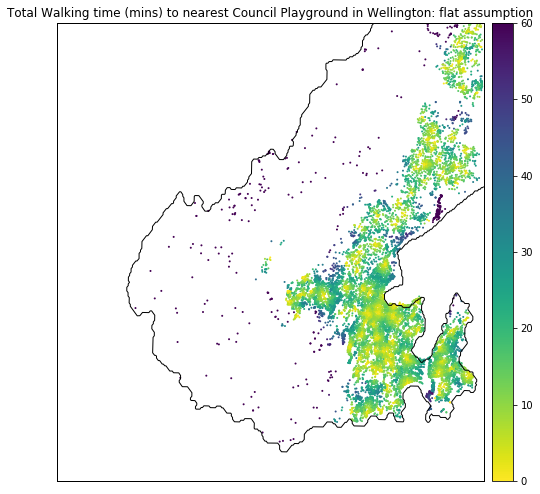

In [24]:
total_flat = (playground_accessibility[1] + playground_accessibility[1])
aa.plot_accessibility(network, total_flat, osm_bbox, 
                      amenity_type='Council Playground', place_name='Wellington',
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)
plt.title('Total Walking time (mins) to nearest Council Playground in Wellington: flat assumption');

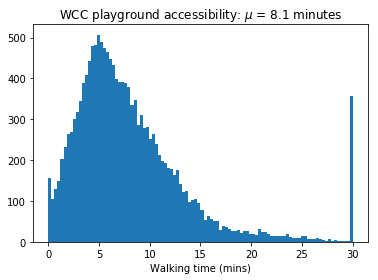

In [25]:
plt.hist(playground_accessibility[1], bins=100);
plt.xlabel('Walking time (mins)');
plt.title("WCC playground accessibility: $\mu$ = {:.1f} minutes".format(np.mean(playground_accessibility[1])));

# Validating the accessibility analysis

[110 John Sim's Drive](https://www.openstreetmap.org/node/6083853567) - Kipling St Play Area
- [Uphill from the park](https://www.google.co.nz/maps/dir/Kipling+Street+Play+Area,+Johnsonville,+Wellington/110+John+Sims+Dr,+Johnsonville,+Wellington+6037/@-41.2287819,174.7921861,15.94z/data=!4m14!4m13!1m5!1m1!1s0x6d38adc0eacfab81:0xb46b5857955895d8!2m2!1d174.797878!2d-41.2251416!1m5!1m1!1s0x6d38ade99a925aa1:0x68fba1d12c2d8b01!2m2!1d174.7921832!2d-41.229301!3e2): 14 minutes
- [Downhill to the park](https://www.google.co.nz/maps/dir/110+John+Sims+Dr,+Johnsonville,+Wellington+6037/Kipling+Street+Play+Area,+Johnsonville,+Wellington/@-41.2287819,174.7921861,15.94z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x6d38ade99a925aa1:0x68fba1d12c2d8b01!2m2!1d174.7921832!2d-41.229301!1m5!1m1!1s0x6d38adc0eacfab81:0xb46b5857955895d8!2m2!1d174.797878!2d-41.2251416!3e2): 11 minutes


In [33]:
'110 John Sims Drive to Kipling Street Play Area: \
Street distance is {:4.0f} m. \
At 5km/hr, it takes {:4.1f} mins. \
Going to the park (downhill) takes {:4.1f} mins. \
Coming back from the park (uphill) takes {:4.1f} mins'.format(playground_accessibility_flat.loc[6083853567][1],
                                                              playground_accessibility.loc[6083853567][1],
                                                              playground_hills_accessibility.loc[6083853567][1],
                                                              playground_hills_inv_accessibility.loc[6083853567][1])

'110 John Sims Drive to Kipling Street Play Area: Street distance is  925 m. At 5km/hr, it takes 11.1 mins. Going to the park (downhill) takes 11.9 mins. Coming back from the park (uphill) takes 12.3 mins'

# Park access isochrones

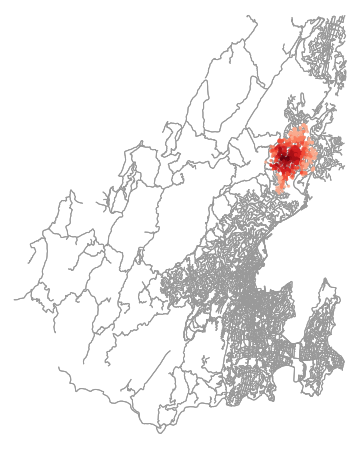

In [34]:
center_node = ox.get_nearest_node(G, (wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']))

trip_times = [5, 10, 15, 20, 25, 30]
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] =  ut.hiking_time(data['grade'], data['length'], params_list=toblers)

iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

[110 John Sims Drive centred map with radius ~1000m](https://www.google.co.nz/maps/place/110+John+Sims+Dr,+Johnsonville,+Wellington+6037/@-41.2293256,174.7884295,1008m/data=!3m1!1e3!4m5!3m4!1s0x6d38ade99a925aa1:0x68fba1d12c2d8b01!8m2!3d-41.229301!4d174.7921832)


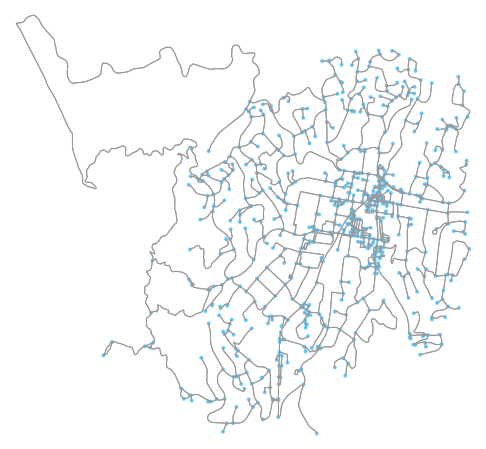

(<Figure size 830.511x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a649af470>)

In [484]:
G_sub = ox.graph_from_point((wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']), distance=1500, network_type='walk')
ox.plot_graph(G_sub, fig_height=8)

In [557]:
G_sub = ox.graph_from_point((wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']), distance=1500, network_type='walk')
center_node = ox.get_nearest_node(G_sub, (wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']))

# Add elevation values for the nodes in the OSMNX graph
G_sub = ox.add_node_elevations(G_sub, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G_sub = ox.add_edge_grades(G_sub)

In [561]:
G_undir = G_sub.to_undirected()
graph_undir_df = ox.graph_to_gdfs(G_undir)
nodes_gdfs_undir = graph_undir_df[0]
edges_gdfs_undir = graph_undir_df[1]

# Get the inverse
edges_gdfs_undir_inv = edges_gdfs_undir.copy()
edges_gdfs_undir_inv['u'] = edges_gdfs_undir['v']
edges_gdfs_undir_inv['v'] = edges_gdfs_undir['u']
edges_gdfs_undir_inv['grade'] = -edges_gdfs_undir['grade']

In [686]:

# Add the travel times 
edges_gdfs_undir['time_tobler'] = ut.hiking_time(edges_gdfs_undir['grade'], edges_gdfs_undir['length'], params_list=toblers)
edges_gdfs_undir_inv['time_tobler'] = ut.hiking_time(edges_gdfs_undir_inv['grade'], edges_gdfs_undir_inv['length'], params_list=toblers)

# Adding hash column
edges_gdfs_undir['prehash'] = edges_gdfs_undir['osmid'].apply(str) + edges_gdfs_undir['u'].apply(str) + edges_gdfs_undir['v'].apply(str)
edges_gdfs_undir_inv['prehash'] = edges_gdfs_undir_inv['osmid'].apply(str) + edges_gdfs_undir_inv['v'].apply(str) + edges_gdfs_undir_inv['u'].apply(str)

edges_gdfs_undir['hash'] = edges_gdfs_undir['prehash'].apply(hash)
edges_gdfs_undir_inv['hash'] = edges_gdfs_undir_inv['prehash'].apply(hash)

# combine undir 
edges_gdfs_undir_inv_sel = edges_gdfs_undir_inv[['time_tobler', 'hash']].rename({'time_tobler': 'time_tobler_inv'}, axis=1)
edges_gdfs_undir_sel = edges_gdfs_undir[['time_tobler', 'hash']].rename({'time_tobler': 'time_tobler_inv'}, axis=1)

gdfs_edges = pd.merge(edges_gdfs_undir, edges_gdfs_undir_inv_sel, on='hash').drop_duplicates(subset = ['hash'])
gdfs_edges['time'] = gdfs_edges['time_tobler'] + gdfs_edges['time_tobler_inv']

# Seem to need (u,v) and (v,u) network for the isochrones plots
gdfs_edges = gdfs_edges.drop(['time_tobler', 'time_tobler_inv'], axis=1).drop_duplicates(subset = ['hash'])
gdfs_edges_inv = gdfs_edges.copy()
gdfs_edges_inv = gdfs_edges_inv.rename({'u': 'v', 'v': 'u'}, axis=1)


# Join reverse network
gdfs_edges = pd.concat([gdfs_edges, gdfs_edges_inv])
G_sub2 = ox.gdfs_to_graph(nodes_gdfs_undir, gdfs_edges)


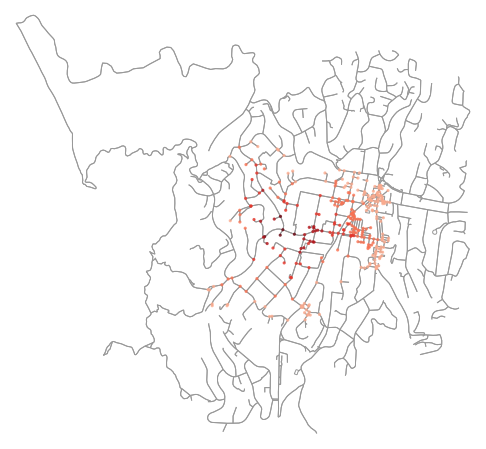

In [701]:
trip_times = [5, 10, 15, 20, 25]

iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G_sub2, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G_sub.nodes()]
ns = [10 if node in node_colors else 0 for node in G_sub.nodes()]
fig, ax = ox.plot_graph(G_sub2, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [692]:
def make_iso_polys(G, trip_times, center_node, edge_buff=25, node_buff=50, infill=False):
    
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = geopandas.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = geopandas.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = geopandas.GeoSeries(all_gs).unary_union
        
        # If desired, try and "fill in" surrounded

        # areas so that shapes will appear solid and blocks

        # won't have white space inside of them

        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

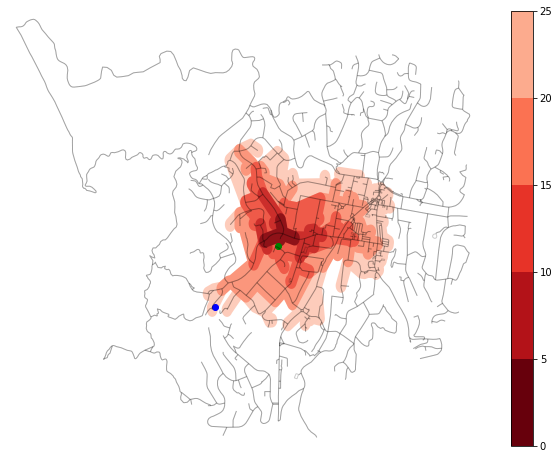

In [753]:
# First, run our new method
trip_times = [5, 10, 15, 20, 25]
isochrone_polys = make_iso_polys(G_sub2, trip_times, center_node, 0.00001*50,  0.00001*50, True)
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
center_node = ox.get_nearest_node(G_sub2, (wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']))

# Add zero to trip_times since we're looking at time intervals for the catchment areas
trip_times.insert(0, 0)

# And use the results in the plot, just as we were performing these steps originally
fig, ax = ox.plot_graph(G_sub2, fig_height=8, show=False, close=False, edge_color='k', 
                        edge_alpha=0.2, node_color='none')

# Add playground and address as points
ax.scatter(174.7922, -41.2292, c='blue')
ax.scatter(wcc_playgrounds.ix[32]['lon'], wcc_playgrounds.ix[32]['lat'], c='green')

# Add catchments as unary union "contour" polygons
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

# Add colorbar
cmap = mpl.colors.ListedColormap(iso_colors[::-1])
norm = mpl.colors.BoundaryNorm(trip_times, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,ticks= trip_times, spacing='proportional')


plt.show()

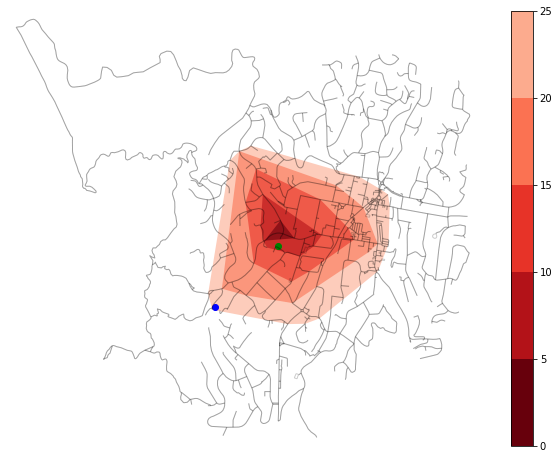

In [694]:
trip_times = [5, 10, 15, 20, 25]
isochrone_polys = []
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G_sub2, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = geopandas.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

    
# plot the network then add isochrones as colored descartes polygon patches

fig, ax = ox.plot_graph(G_sub2, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')

# Add playground and address as points
ax.scatter(174.7922, -41.2292, c='blue')
ax.scatter(wcc_playgrounds.ix[32]['lon'], wcc_playgrounds.ix[32]['lat'], c='green')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
# Add zero to trip_times since we're looking at time intervals for the catchment areas
trip_times.insert(0, 0)

# Add colorbar
cmap = mpl.colors.ListedColormap(iso_colors[::-1])
norm = mpl.colors.BoundaryNorm(trip_times, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,ticks= trip_times, spacing='proportional')


plt.show()

In [695]:
G_sub = ox.graph_from_point((wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']), distance=1500, network_type='walk')

c = ox.graph_to_gdfs(G_sub)
g_nodes = c[0]
g_edges = c[1]

In [696]:
x = g_edges.query('v == 6083915778')
y = g_edges.query('u == 6083915778')

x['hash'] = x['osmid'].apply(str).apply(hash)
y['hash'] = y['osmid'].apply(str).apply(hash)


tog = pd.merge(x, y, on='hash')

In [555]:
y

,bridge,geometry,highway,junction,key,length,maxspeed,name,oneway,osmid,service,tunnel,u,v,hash
1,NaN,"LINESTRING (174.7989674 -41.2333596, 174.79896...",service,NaN,0,126.595,NaN,NaN,False,"[647922120, 647922123, 647922119]",parking_aisle,NaN,6083915778,6083915782,-3047474012915976670


In [755]:
# Get nearest nodes for validation coordinates: 110 John Sim's Drive and Kipling St Play Area
playground_node = ox.get_nearest_node(G_sub2, (wcc_playgrounds.ix[32]['lat'], wcc_playgrounds.ix[32]['lon']))
start_node = ox.get_nearest_node(G_sub2, (-41.2292, 174.7922))

# Get the OSMIDs of the shortest path
route = network_hills.shortest_path(node_a=playground_node, node_b=start_node)

# Convert route to [u,v] representation
from_route = np.roll(route,-1)
df = pd.DataFrame({'u': route, 'v': from_route})[0:len(route)-1]
df['uv_comb'] = df['u'].apply(str) + df['v'].apply(str)

# Join with edges DF extracted from the subgraph
gdfs_edges['uv_comb'] = gdfs_edges['u'].apply(str) + gdfs_edges['v'].apply(str)
route_df = gdfs_edges[gdfs_edges['uv_comb'].isin(df['uv_comb'])]

# Calculate some metrics
print('Route is {:4.0f} m long and takes {:4.1f} mins'.format(route_df['length'].sum(), route_df['time'].sum()))

Route is  925 m long and takes 24.3 mins


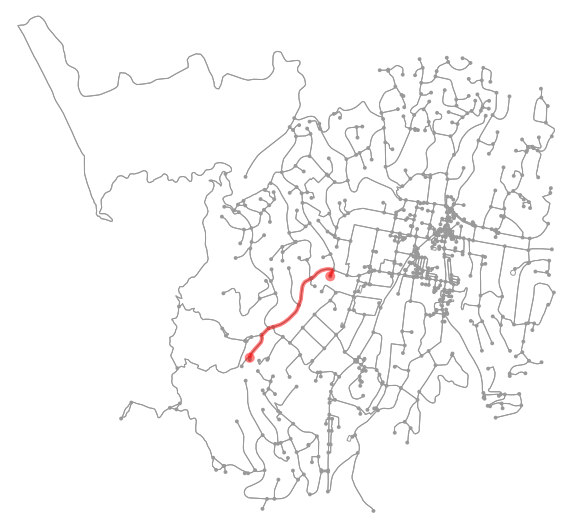

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a73fe51d0>)

In [749]:
ox.plot_graph_route(G_sub2, route, fig_height=10, fig_width=10)

# Validating pandana with Graphhopper Routing API

Visualised [here](https://www.openstreetmap.org/directions?engine=graphhopper_foot&route=-41.28228%2C174.76145%3B-41.28352%2C174.76559#map=17/-41.28247/174.76603)

In [170]:
graph_hopper_api_key = data_loaded['graph_hopper_api_key'][0]
graph_hopper_query = "https://graphhopper.com/api/1/route?point=-41.2292,174.7922&point=-41.2253,174.7976&vehicle=foot&points_encoded=false&locale=nz&key=" + graph_hopper_api_key

In [171]:
%%bash -s "$graph_hopper_query"
curl $1

{"hints":{"visited_nodes.average":"28.0","visited_nodes.sum":"28"},"info":{"copyrights":["GraphHopper","OpenStreetMap contributors"],"took":4},"paths":[{"distance":1007.3,"weight":603.101372,"time":725253,"transfers":0,"points_encoded":false,"bbox":[174.792028,-41.229148,174.798734,-41.22499],"points":{"type":"LineString","coordinates":[[174.792028,-41.229148],[174.792089,-41.229032],[174.792403,-41.228742],[174.792854,-41.228362],[174.792949,-41.228113],[174.792882,-41.22792],[174.793009,-41.227871],[174.793469,-41.227519],[174.79382,-41.227449],[174.79396,-41.227773],[174.794037,-41.227829],[174.794583,-41.228031],[174.795135,-41.228387],[174.79614,-41.227492],[174.797424,-41.226418],[174.797595,-41.226301],[174.79831,-41.225888],[174.79852,-41.22564],[174.798734,-41.225427],[174.798559,-41.225274],[174.798037,-41.225018],[174.797925,-41.22499],[174.797878,-41.224999],[174.797832,-41.225054],[174.797679,-41.225337],[174.797637,-41.225354]]},"instructions":[{"distance":163.218,"headin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2069  100  2069    0     0   1224      0  0:00:01  0:00:01 --:--:--  1223


In [192]:
coords = [[174.792028,-41.229148],[174.792089,-41.229032],[174.792403,-41.228742],[174.792854,-41.228362],[174.792949,-41.228113],[174.792882,-41.22792],[174.793009,-41.227871],[174.793469,-41.227519],[174.79382,-41.227449],[174.79396,-41.227773],[174.794037,-41.227829],[174.794583,-41.228031],[174.795135,-41.228387],[174.79614,-41.227492],[174.797424,-41.226418],[174.797595,-41.226301],[174.79831,-41.225888],[174.79852,-41.22564],[174.798734,-41.225427],[174.798559,-41.225274],[174.798037,-41.225018],[174.797925,-41.22499],[174.797878,-41.224999],[174.797832,-41.225054],[174.797679,-41.225337],[174.797637,-41.225354]]

In [186]:
ox.get_nearest_node(G_sub, (-41.225337,174.797679))

4946729395

OutMultiEdgeDataView([(333987846, 300553882, 0, {'osmid': 27378751, 'name': 'Sirsi Terrace', 'highway': 'residential', 'maxspeed': '50', 'oneway': False, 'length': 22.226}), (333987846, 300553686, 0, {'osmid': 27378751, 'name': 'Sirsi Terrace', 'highway': 'residential', 'maxspeed': '50', 'oneway': False, 'length': 51.491, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a41c71c88>}), (333987846, 509903379, 0, {'osmid': 30293905, 'highway': 'track', 'oneway': False, 'length': 171.94500000000002, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a41c719e8>}), (1105821864, 1105821874, 0, {'osmid': 95350617, 'name': 'McLintock Street', 'highway': 'residential', 'maxspeed': '50', 'oneway': False, 'length': 119.994, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a47f9e7b8>}), (1105821864, 6252781125, 0, {'osmid': [667787915, 166080335], 'name': ['McLintock Street', 'Old Coach Road'], 'highway': ['track', 'residential'], 'maxspeed': '50', 'onew